In [10]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model
import time
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt
import math
import pickle


In [11]:
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    try:
        with open(name + '.pkl', 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {}

In [12]:
# generate data
def generate_data(nb_query=25, mean_doc_per_query=10):
    query = np.repeat(np.arange(nb_query)+1, np.ceil(np.abs(np.random.normal(mean_doc_per_query, size=nb_query, scale=0.15*mean_doc_per_query))+2).astype(np.int))
    doc_features = np.random.random((len(query), 10))
    doc_scores = np.random.randint(5, size=len(query)).astype(np.float32)

    # put data into pairs
    pair_id = []
    pair_query_id = []
    for q in np.unique(query):
        query_idx = np.where(query == q)[0]
        for pair_idx in combinations(query_idx, 2):
            pair_query_id.append(q)        
            pair_id.append(pair_idx)

    pair_id = np.array(pair_id)
    pair_query_id = np.array(pair_query_id)

    pair_id_train, pair_id_test, pair_query_id_train, pair_query_id_test = train_test_split(pair_id, pair_query_id, test_size=0.2, stratify=pair_query_id)
    
    return query, doc_features, doc_scores, pair_id, pair_id_train, pair_id_test, pair_query_id, pair_query_id_train, pair_query_id_test


In [13]:
nb_query = 10
mean_doc_per_query = 5
query, doc_features, doc_scores, pair_id, pair_id_train, pair_id_test, pair_query_id, pair_query_id_train, pair_query_id_test = generate_data(nb_query, mean_doc_per_query)


In [14]:
# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))


class FactorisedRankNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
    
    def call(self, inputs):
        xi = inputs
        densei = self.dense[0](xi)
        for dense in self.dense[1:]:
            densei = dense(densei)
        oi = self.o(densei)
        return oi
    
    def build_graph(self):
        x = tf.keras.Input(shape=(10))
        return tf.keras.Model(inputs=x, outputs=self.call(x))
        

In [18]:
#
# Functions for training RankNet
#

# compute gradient and do backpropagation
def apply_gradient(optimizer, loss_object, model, x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss_value = loss_object(y, y_pred)
    
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return y_pred, loss_value


# compute loss on validation set
def compute_val_loss_efficient(loss_object, model):
    losses = []
    _xi = doc_features[pair_id_test[:,0]]
    _xj = doc_features[pair_id_test[:,1]]
    scorei = doc_scores[pair_id_test[:,0]]
    scorej = doc_scores[pair_id_test[:,1]]
    _pij = (scorei > scorej).astype(float)
    _pij[scorei==scorej] = 0.5
    _pij = _pij.reshape(-1,1)
    
    pij_pred = model([_xi, _xj])
    loss_value = loss_object(y_true=_pij, y_pred=pij_pred)
    losses.append(loss_value)
    
    return losses


# train for one epoch
def train_data_for_one_epoch_efficient(optimizer, loss_object, model, steps_total=None, apply_gradient=apply_gradient):
    losses = []
    
    pb_i = Progbar(steps_total)
    for (i,j) in pair_id_train:
        _xi = doc_features[[i]]
        _xj = doc_features[[j]]
        _pij = [[0.5]]
        if doc_scores[i] < doc_scores[j]:
            _pij = [[0]]
        elif doc_scores[i] > doc_scores[j]:
            _pij = [[1]]
        y_pred, loss_value = apply_gradient(optimizer, loss_object, model, [_xi, _xj], _pij)
        losses.append(loss_value)

        pb_i.add(1)
    
    return losses


In [19]:
def get_data(query_id, pair_id, pair_query_id):
    if type(query_id) is not np.ndarray:
        query_id = np.array([query_id]).ravel()
    _ind = np.hstack([np.where(query==i) for i in query_id]).ravel()

    q_unique, q_index, q_cnt  = np.unique(query, return_index=True, return_counts=True)
    doc_cnt = q_cnt[np.searchsorted(q_unique, query_id)].sum()
    x = doc_features[_ind]
    score = doc_scores[_ind]
    
    mask = np.zeros((doc_cnt, doc_cnt), dtype=np.float32)
    _, new_q_index = np.unique(query[_ind], return_index=True)
    _pair_id = np.vstack([pair_id[np.where(pair_query_id==i)] - q_index[q_unique==i] + new_q_index[query_id==i] for i in query_id])
    mask[_pair_id[:,0], _pair_id[:,1]] = 1

    return tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(score, dtype=tf.float32), tf.convert_to_tensor(mask, dtype=tf.float32), tf.convert_to_tensor(doc_cnt, dtype=tf.float32)


def apply_gradient_factorised(optimizer, model, x, score, mask, doc_cnt):
    with tf.GradientTape() as tape:
        oi = model(x)
    
    S_ij = tf.maximum(tf.minimum(tf.subtract(tf.expand_dims(score,1), score),1.),-1.)
    P_ij = tf.multiply(mask, tf.multiply(0.5, tf.add(1., S_ij)))
    P_ij_pred = tf.multiply(mask,tf.nn.sigmoid(tf.subtract(oi, tf.transpose(oi))))
    lambda_ij = tf.add(tf.negative(P_ij), P_ij_pred)
    lambda_i = tf.reduce_sum(lambda_ij,1) - tf.reduce_sum(lambda_ij,0)
    
    doi_dwk = tape.jacobian(oi, model.trainable_weights)
    
    # 1. reshape lambda_i to match the rank of the corresponding doi_dwk
    # 2. multiple reshaped lambda_i with the corresponding doi_dwk
    # 3. compute the sum across first 2 dimensions
    gradients = list(map(lambda k: 
                         tf.reduce_sum(tf.multiply(tf.reshape(lambda_i,  tf.concat([tf.shape(lambda_i),tf.ones(tf.rank(k) - 1, dtype=tf.int32)], axis=-1)), k), [0,1]),
                         doi_dwk))
    
    # model could still be trained without calculating the loss below
    valid_pair_cnt = tf.reduce_sum(mask)
    loss_value = tf.reduce_sum(tf.keras.losses.binary_crossentropy(P_ij, P_ij_pred))
    loss_value = tf.multiply(loss_value, doc_cnt)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return oi, loss_value


def train_data_for_one_epoch_factorised(optimizer, model, batch_size=1, apply_gradient=apply_gradient_factorised):
    losses = []
    
    pb_i = Progbar(np.ceil(len(np.unique(query)) // batch_size), stateful_metrics=['loss'])
    _query = np.unique(query)
    np.random.shuffle(_query)
    for step, query_id in enumerate(_query):
        x, score, mask, doc_cnt= get_data(query_id, pair_id_train, pair_query_id_train)
        y_pred, loss_value = apply_gradient(optimizer, model, x, score, mask, doc_cnt)
        losses.append(loss_value)

        pb_i.add(1)
    return losses

def compute_val_loss_factorised(model):
    # compute cross entropy loss
    losses = []

    x, score, mask, doc_cnt = get_data(np.unique(query), pair_id_test, pair_query_id_test)
    oi = model(x)

    S_ij = tf.maximum(tf.minimum(tf.subtract(tf.expand_dims(score,1), score),1.),-1.)
    P_ij = tf.multiply(mask, tf.multiply(0.5, tf.add(1., S_ij)))
    P_ij_pred = tf.multiply(mask,tf.nn.sigmoid(tf.subtract(oi, tf.transpose(oi))))
    valid_pair_cnt = tf.reduce_sum(mask)
    loss_value = tf.reduce_sum(tf.keras.losses.binary_crossentropy(P_ij, P_ij_pred))
    loss_value = tf.divide(tf.multiply(loss_value, doc_cnt), valid_pair_cnt)

    losses.append(loss_value)

    return losses


In [ ]:
epoch_time_ranknet = load_obj('epoch_time_ranknet')
epoch_time_facranknet = load_obj('epoch_time_facranknet')
epoch_loss_ranknet = load_obj('epoch_loss_ranknet')
epoch_loss_facranknet = load_obj('epoch_loss_facranknet')

for mean_doc_per_query in [50]:
    print('================')
    print('================')
    print('================')
    print(mean_doc_per_query)
    print('================')
    print('================')
    print('================')
    
    epochs = 50
    nb_query = 25

    epoch_time_ranknet[mean_doc_per_query] = []
    epoch_time_facranknet[mean_doc_per_query] = []
    epoch_loss_ranknet[mean_doc_per_query] = {'trainloss':[], 'testloss':[]}
    epoch_loss_facranknet[mean_doc_per_query] = {'trainloss':[], 'testloss':[]}

    # generate data
    query, doc_features, doc_scores, pair_id, pair_id_train, pair_id_test, pair_query_id, pair_query_id_train, pair_query_id_test = generate_data(25, mean_doc_per_query)
    
    #
    # ranknet
    #
    ranknet = RankNet()

    loss_object = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.Adam()
    loss_train_history = []
    loss_val_history = []
    apply_gradient_graph = tf.function(apply_gradient)
    for epoch in range(epochs):
        time_start = time.perf_counter()
        print('Epoch %d/%d'%(epoch+1, epochs))
        losses_train = train_data_for_one_epoch_efficient(optimizer, loss_object, ranknet, pair_id_train.shape[0], apply_gradient_graph)
        epoch_time_ranknet[mean_doc_per_query].append(time.perf_counter() - time_start)
        
        _loss_train = np.mean(losses_train)
        _loss_val = np.mean(compute_val_loss_efficient(loss_object, ranknet))
        loss_train_history.append(_loss_train)
        loss_val_history.append(_loss_val)
        print('Train loss: %.4f  Validation Loss: %.4f' % (_loss_train, _loss_val))
        epoch_loss_ranknet[mean_doc_per_query]['trainloss'].append(_loss_train)
        epoch_loss_ranknet[mean_doc_per_query]['testloss'].append(_loss_val)

    #
    # factorised ranknet
    #
    fac_ranknet = FactorisedRankNet()

    epochs = epochs*100
    optimizer = tf.keras.optimizers.Adam()
    loss_train_history = []
    loss_val_history = []
    apply_gradient_graph = tf.function(apply_gradient_factorised, experimental_relax_shapes=True)
    for epoch in range(epochs):
        time_start = time.perf_counter()
        print('Epoch %d/%d'%(epoch+1, epochs))
        losses_train = train_data_for_one_epoch_factorised(optimizer, fac_ranknet, apply_gradient=apply_gradient_graph)
        epoch_time_facranknet[mean_doc_per_query].append(time.perf_counter() - time_start)
        
        _loss_train = np.sum(losses_train)/pair_id_train.shape[0]
        _loss_val = np.mean(compute_val_loss_factorised(fac_ranknet))
        loss_train_history.append(_loss_train)
        loss_val_history.append(_loss_val)
        print('Train loss: %.4f  Validation Loss: %.4f' % (_loss_train, _loss_val))
        epoch_loss_facranknet[mean_doc_per_query]['trainloss'].append(_loss_train)
        epoch_loss_facranknet[mean_doc_per_query]['testloss'].append(_loss_val)
    
    save_obj(epoch_time_ranknet, 'epoch_time_ranknet')
    save_obj(epoch_loss_ranknet, 'epoch_loss_ranknet')
    save_obj(epoch_time_facranknet, 'epoch_time_facranknet')
    save_obj(epoch_loss_facranknet, 'epoch_loss_facranknet')


50
Epoch 1/50
26191/26191 [==============================] - 11s 427us/step
Train loss: 0.6862  Validation Loss: 0.6807
Epoch 2/50
26191/26191 [==============================] - 11s 419us/step
Train loss: 0.6720  Validation Loss: 0.6709
Epoch 3/50
15745/26191 [=================>............] - ETA: 4s

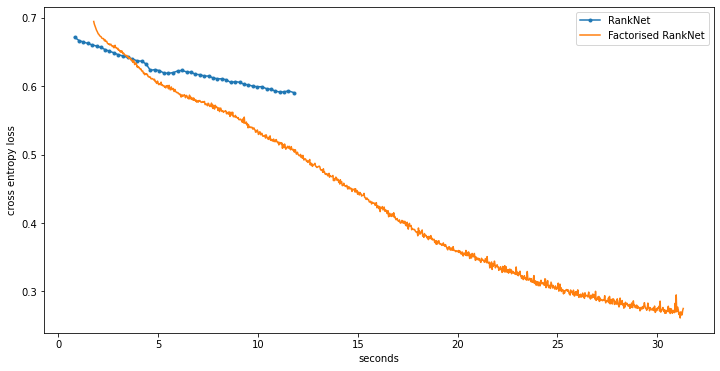

In [23]:
key = 5
x = np.cumsum(epoch_time_ranknet[key])
y = epoch_loss_ranknet[key]['testloss']

x_fac = np.cumsum(epoch_time_facranknet[key])
y_fac = epoch_loss_facranknet[key]['testloss']

plt.figure(figsize=(12,6))
plt.plot(x, y, marker='.', label="RankNet")
plt.plot(x_fac, y_fac, label="Factorised RankNet")
plt.ylabel('cross entropy loss')
plt.xlabel('seconds')
plt.legend()
plt.show()